<a href="https://colab.research.google.com/github/Forest-shot/BCI_MI_CSP_DNN/blob/master/%E2%80%9CEEGClassification_CrossValidation_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Edgar Moises Hernandez-Gonzalez
#### Asesores: Pilar Gomez-Gil, Erik Bojorges-Valdez
#### Instituto Nacional de Astrofísica Óptica y Electrónica (INAOE)
#### 25/11/20-03/12/20
#### Tesis: Clasificación de señales EEG basada en representaciones bidimensionales y redes neuronales convolucionales
#### Clasificacion de EEG con CNN-2D o CNN-2D + LSTM
##### Caracteristicas = Espectrogramas STFT o Escalogramas CWT

##### Entrenamiento y evaluacion de CNN-2D o CNN-2D + LSTM con STFT o CWT
##### Validacion cruzada

In [2]:
# activar google drive
# no es necesario si se ejecuta local
from google.colab import drive

In [3]:
# montar drive
# no es necesario si se ejecuta local
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ejecutar desde aqui si se ejecuta en su computadora local, importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
import pywt
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                          TimeDistributed, LSTM)
from tensorflow.keras.optimizers import Adam
from keras import backend as K

In [5]:
# para que este script funcione debe de decir 'channels_last'
# si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [6]:
# leer .csv con los datos de train y test
# se debe especificar la ruta
# header = None significa que los .csv no tienen encabezado
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/MI-EEG-B9T.csv",
                      header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/MI-EEG-B9E.csv",
                     header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/etiquetas_train_9.csv",
                      header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/etiquetas_test_9.csv",
                     header=None)

In [7]:
# imprimir la forma de las matrices de datos
# x_train y x_test son matrices donde las filas son el numero de ejemplos
# y las columnas son el numero de segundos por la frecuencia de muestreo
# por el numero de canales
# y_train y y_test son las etiquetas
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 3000)
(320, 3000)
(400, 1)
(320, 1)


In [8]:
# unir train y test, despues se hara la division con cross-validation
# x (matrices) lo unimos con pandas (mas facil para el calculo de STFT o CWT)
# y (etiquetas) lo unimos con numpy
x = pd.concat([x_train, x_test])
y = np.concatenate((y_train, y_test))

In [9]:
# imprimir la forma de las matrices de datos
print(x.shape)
print(y.shape)

(720, 3000)
(720, 1)


In [10]:
# calcular el numero de muestras
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 720


In [11]:
# calcular el numero de clases
# esto se podria calcular asi n_clases = len(np.unique(y))
# la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 2


In [12]:
# calcular espectrogramas con STFT
# concatenacion vertical de los espectrogramas de los n canales
# unir_espectrogramas_vertical(matriz de x_train o x_test,
# frecuencia de muestreo, alto, ancho, n_canales, tamano del segmento de senal,
# puntos superpuestos para calcular la STFT)
def unir_espectrogramas_vertical(data, fs, alto, ancho, n_canales, pts_sig,
                                 pts_superpuestos):
  #fs = fs #frecuencia de muestreo
  # crear matriz 3D para almacenar todas las imagenes de los STFT
  datos = np.zeros((data.shape[0],alto, ancho))
  
  # crear matriz 2D donde se guardara cada imagen del STFT
  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]): # n muestras
    for j in range(n_canales): # n canales
      # puntos_sig = duracion en segundos de la señal x frecuencia de muestreo
      # para una señal de 2 seg con fs de 250 Hz, puntos_sig = 500
      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]
      
      # espectrograma con STFT
        # senal,
        # fs=frecuencia de muestreo,
        # window='tipo de ventana',
        # nperseg=tamano de ventana,
        # noverlap=puntos superpuestos,
        # nfft=tamano de la FFT con relleno de ceros, Si=None la longitud de FFT es nperseg
        # scaling=‘density’: power spectral density, ‘spectrum’: power spectrum
      f, t, Sxx = spectrogram(sig, fs=fs, window='hann', nperseg=fs,
                              noverlap=pts_superpuestos, nfft=fs*2,
                              scaling='spectrum')
      
      # concatenacion vertical de canales
      # espectrograma genera 45 filas (frecuencias de 8 a 30Hz con pasos de
      # 0.5Hz) y 31 columnas (tiempo)
      # las frecuncias de 8 a 30 Hz estan entre los indices de 16 a 60
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]

    datos[i] = temporal
    if i % 100 == 0: # esto es para ver como avanza
      print(i)
  return datos

In [13]:
# calcular escalogramas con CWT
# concatenacion vertical de los escalogramas de los n canales
# unir_escalogramas_vertical(matriz de x_train o x_test, frecuencia de muestreo,
# alto, ancho, n_canales, tamano del segmento de senal):
def unir_escalogramas_vertical(data, fs, alto, ancho, n_canales, pts_sig):
  # ancho y alto, para el resize usando Open CV
  dim = (int(np.floor(ancho/2)), int(np.floor(alto/2))) # ancho, alto
  
  # calcular escalas para Wavelet compleja de Morlet 3-3
  # con frecuencias de 8 a 30 Hz con pasos de 0.5 Hz
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  
  # crear matriz 3D para almacenar todas las imagenes
  datos = np.zeros((data.shape[0], int(np.floor(alto/2)),
                    int(np.floor(ancho/2))))
  
  # crear matriz 2D donde se guardara cada imagen
  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]): # n muestras
    for j in range(n_canales): # n canales
      # puntos_sig = duracion en segundos de la señal x frecuencia de muestreo
      # para una señal de 2 seg con fs de 250 Hz, puntos_sig = 500
      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]
      
      # escalograma con CWT
        # senal
        # escalas
        # nombre de la wavelet, en este caso compleja de Morlet 3-3
        # periodo de muestreo = 1 / frecuencia de muestreo
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3',
                             sampling_period = (1 / fs))
      
      # concatenacion vertical de canales
      # espectrograma genera 45 filas (frecuencias de 8 a 30Hz con pasos de
      # 0.5Hz) y 31 columnas (tiempo)
      # dado que cmor3-3 genera numeros complejos, calcular el modulo
      temporal[j*45:(j+1)*45, :] = abs(coef)

    # resize usando una interpolacion interarea con OpenCV
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: # esto solo es para ver como avanza
      print(i)
  return datos

In [14]:
# seleccionar STFT o CWT
inicio = time.time()

# STFT, llamar a unir_espectrogramas_vertical(data, fs, alto, ancho,
# n_canales, pts_sig, pts_superpuestos))
# descomentar la siguiente linea para STFT
x = unir_espectrogramas_vertical(x, 250, 135, 31, 3, 1000, 225)

# CWT, llamar a unir_escalogramas_vertical(data, fs, alto, ancho,
# n_canales, pts_sig)
# descomentar la siguiente linea para CWT
#x = unir_escalogramas_vertical(x, 250, 135, 1000, 3, 1000)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
400
500
600
700
Tiempo: 2.153381586074829


In [15]:
# forma de los espectrogramas (STFT) o escalogramas (CWT)
# la forma debe ser tridimensional
# la primera dimension es igual al numero de ejemplos
# la segunda dimension es lo alto de las imagenes calculadas con STFT o CWT
# la tercera dimension es lo ancho de las imagenes calculadas con STFT o CWT
print(x.shape)

(720, 135, 31)


In [16]:
# imprimir el maximo, minimo y la media del x (imagenes de STFT o CWT)
print(np.max(x))
print(np.min(x))
print(np.mean(x))

10.7888912416627
3.407406192918792e-08
0.06609588538579113


In [17]:
# convertir a float
x = x.astype('float32')

# escalar los valores en un rango de 0 a 1 (normalizar)
# dividir entre el max redondeado al techo
x /= np.ceil(np.max(x))

In [18]:
# imprimir el maximo, minimo y la media del x (imagenes de STFT o CWT)
# despues de normalizar los datos
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.98080826
3.0976421e-09
0.006008719


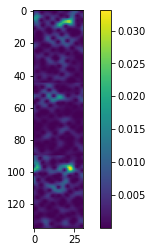

In [19]:
# mostrar el ejemplo 2 de x_train
plt.figure()
plt.imshow(x[1])
plt.colorbar()
plt.show()

In [20]:
# seleccionar reshape a 4D (para CNN-2D) o 5D (para CNN-2D + LSTM)
# para CNN-2D usar a 4D, para CNN-2D + LSTM usar a 5D

# convertir de 3D a 4D (CNN-2D)
# descomentar la siguiente linea para usar CNN-2D
x = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))

# convertir de 3D a 5D (CNN-2D + LSTM)
# descomentar la siguiente linea para usar CNN-2D + LSTM
#x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], 1))

# imprimir la forma
print(x.shape)
print(x.shape)

(720, 135, 31, 1)
(720, 135, 31, 1)


In [21]:
# n_splits: numero de folds para cross-validation estratificado
skf = StratifiedKFold(n_splits = 10)

In [22]:
# crear red neuronal CNN-2D
# se debe especificar el numero de filtros, el tamano de los filtros
# y el numero de neuronas en la capa oculta del MLP (Dense)
# modelo secuencial de dos capas convolucionales 2D con activacion relu y
# relleno de ceros y max pooling de 2x2
# aplanar los mapas de caracteristicas para convertirlas de una matriz 3D a
# un vector 1D
# MLP de una capa oculta con relu
# regularizacion con dropout de 0.5
# la ultima capa utiliza una funcion softmax para obtener una distribucion
# de probabilidad
# optimizador Adam con tasa de aprendizaje de 1x10-4
# la funcion de perdida es la entropia cruzada categorica
# (se utiliza sparse para no convertir las etiquetas a one hot)
# la metrica a evaluar es el accuracy
def CNN_2D(n_filtros, tamano_filtros, n_neuronas):
  model = Sequential()
  model.add(Conv2D(n_filtros, tamano_filtros, activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(n_filtros, tamano_filtros, activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(n_neuronas, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [23]:
# crear red neuronal CNN-2D + LSTM
# se debe especificar el numero de filtros, el tamano de los filtros,
# el numero de neuronas en la capa oculta del MLP (Dense) y el numero de
# unidades LSTM 
# modelo secuencial de dos capas convolucionales 2D con activacion relu y
# relleno de ceros y max pooling de 2x2
# aplanar los mapas de caracteristicas para convertirlas de una matriz 3D a
# un vector 1D
# red recurrente LSTM con activacion tangente hiperbolica y dropout de 0.5
# (esta va entre las capas convolucionales y el MLP)
# MLP de una capa oculta con relu
# regularizacion con dropout de 0.5
# la ultima capa utiliza una funcion softmax para obtener una distribucion
# de probabilidad
# optimizador Adam con tasa de aprendizaje de 1x10-4
# la funcion de perdida es la entropia cruzada categorica
# (se utiliza sparse para no convertir las etiquetas a one hot)
# la metrica a evaluar es el accuracy
# para poder conectar CNN-2D con LSTM se debe utilizar la capa TimeDistributed
def CNN_2D_LSTM_TD(n_filtros, tamano_filtros, n_neuronas, unidades_LSTM):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(n_filtros, tamano_filtros, activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(n_filtros, tamano_filtros, activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(unidades_LSTM, activation='tanh', dropout=0.5))
  model.add(Dense(n_neuronas, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


loss:  1.4100786447525024
accuracy:  0.5972222089767456
kappa:  0.19444444444444442
confusion matrix:
 [[11 25]
 [ 4 32]]


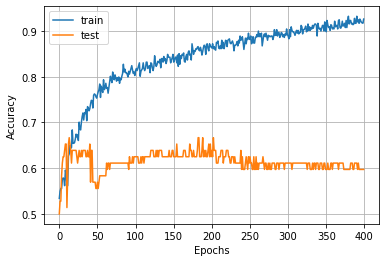

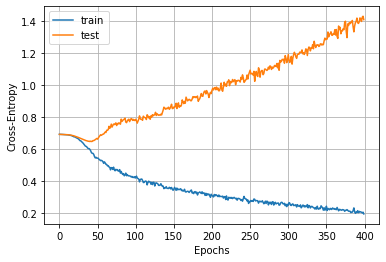


Iteration: 2
loss:  1.748609185218811
accuracy:  0.6111111044883728
kappa:  0.2222222222222222
confusion matrix:
 [[22 14]
 [14 22]]


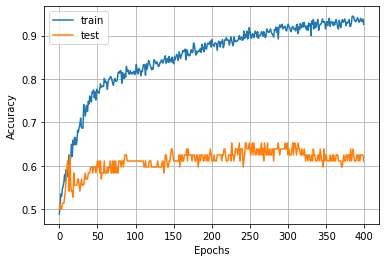

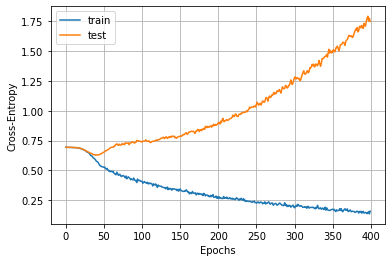


Iteration: 3
loss:  1.4227243661880493
accuracy:  0.5833333134651184
kappa:  0.16666666666666663
confusion matrix:
 [[21 15]
 [15 21]]


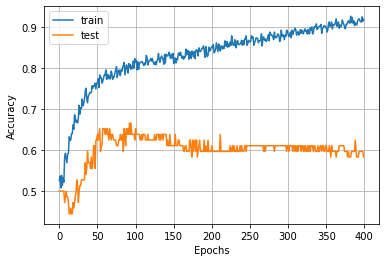

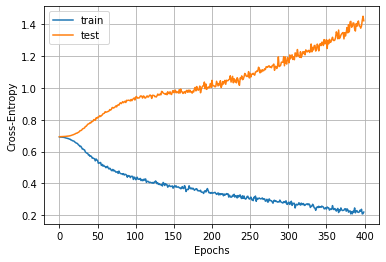


Iteration: 4
loss:  0.7675726413726807
accuracy:  0.7083333134651184
kappa:  0.41666666666666663
confusion matrix:
 [[26 10]
 [11 25]]


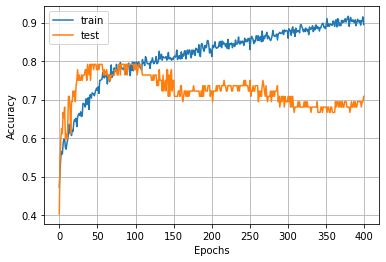

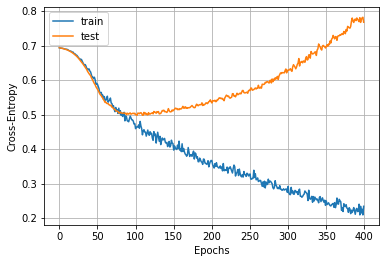


Iteration: 5
loss:  0.35155752301216125
accuracy:  0.8333333134651184
kappa:  0.6666666666666667
confusion matrix:
 [[26 10]
 [ 2 34]]


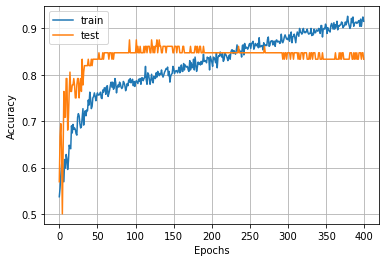

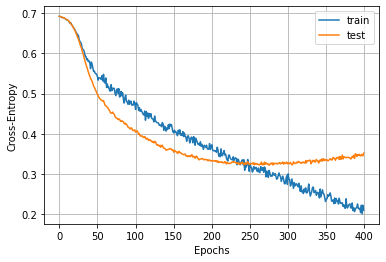


Iteration: 6
loss:  0.39640605449676514
accuracy:  0.8472222089767456
kappa:  0.6944444444444444
confusion matrix:
 [[29  7]
 [ 4 32]]


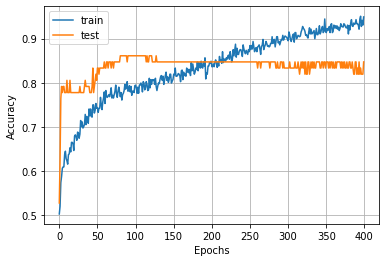

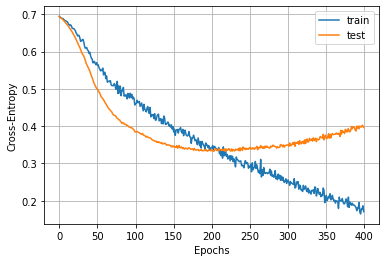


Iteration: 7
loss:  0.45176538825035095
accuracy:  0.8333333134651184
kappa:  0.6666666666666667
confusion matrix:
 [[27  9]
 [ 3 33]]


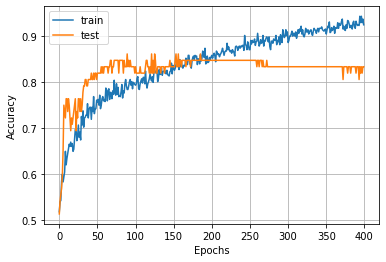

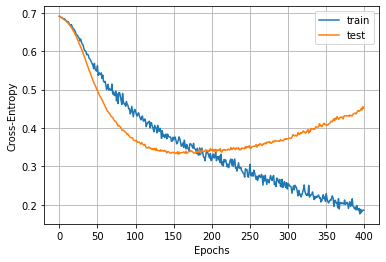


Iteration: 8
loss:  0.360744833946228
accuracy:  0.875
kappa:  0.75
confusion matrix:
 [[35  1]
 [ 8 28]]


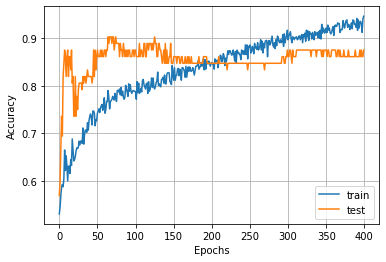

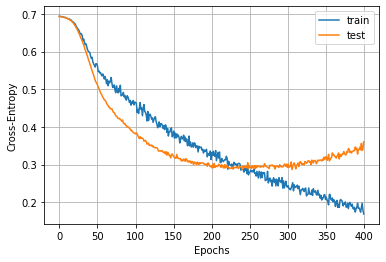


Iteration: 9
loss:  0.4211532175540924
accuracy:  0.7777777910232544
kappa:  0.5555555555555556
confusion matrix:
 [[31  5]
 [11 25]]


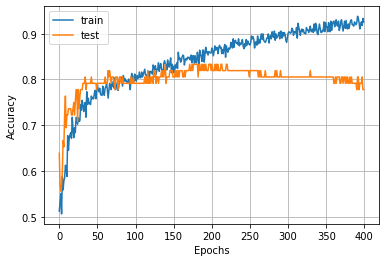

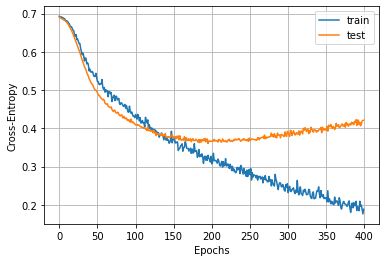


Iteration: 10
loss:  0.7167287468910217
accuracy:  0.8611111044883728
kappa:  0.7222222222222222
confusion matrix:
 [[36  0]
 [10 26]]


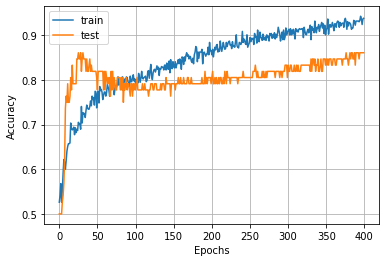

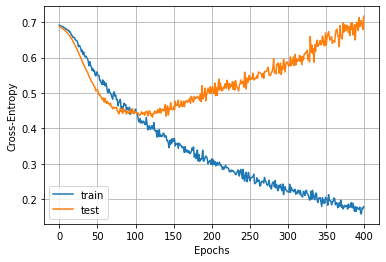


Resultados:
loss: [1.4100786447525024, 1.748609185218811, 1.4227243661880493, 0.7675726413726807, 0.35155752301216125, 0.39640605449676514, 0.45176538825035095, 0.360744833946228, 0.4211532175540924, 0.7167287468910217]
accuracy: [0.5972222089767456, 0.6111111044883728, 0.5833333134651184, 0.7083333134651184, 0.8333333134651184, 0.8472222089767456, 0.8333333134651184, 0.875, 0.7777777910232544, 0.8611111044883728]
kappa: [0.19444444444444442, 0.2222222222222222, 0.16666666666666663, 0.41666666666666663, 0.6666666666666667, 0.6944444444444444, 0.6666666666666667, 0.75, 0.5555555555555556, 0.7222222222222222]
Tiempo: 690.5448114871979


In [24]:
inicio = time.time()
array_loss = [] # arreglo para las perdidas
array_acc = [] # arreglo para los accuracy
array_kappa = [] # arreglo para las kappas
i = 0
# obtener los indices para train y test en cada ejecucion
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  # seleccionar la red neuronal
  model = CNN_2D(4, (3,3), 32)
  #model = CNN_2D_LSTM_TD(4, (3,3), 32, 4)

  # para STFT = 400 epochs, para CWT = 100 epochs
  # batch_size: su tamano es opcional (depende del dataset)
  # entrenar red neuronal
    # para STFT = 400 epochs, para CWT = 100 epochs
    # batch_size: su tamano es opcional (depende del dataset)
    # x_train: matriz
    # y_train: etiquetas
    # epochs: numero epocas
    # batch_size: tamano del lote (entre mas pequeño tarda mas el entrenamiento)
    # validation_data: estos datos son para evaluar la red en cada epoca, es
      # importante mencionar que estos datos no se utilizan para entrenar la
      # red solo son para evaluar en cada epoca
    # verbose: 0 para no imprimir el proceso de entrenamiento, otras opciones
      # pueden ser 1 o 2
  history = model.fit(x_train, y_train, epochs=400, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)
    
  # evaluar red neuronal con x_test y y_test
  # (datos que nunca se le presentaron a la red en el entrenamiento)
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss) # agregar test_loss al arreglo array_loss
  print("loss: ", test_loss)
  array_acc.append(test_acc) # agregar test_acc al arreglo array_acc
  print("accuracy: ", test_acc)
  
  # predecir x_test (distribucion de probabilidad)
  probabilidades = model.predict(x_test)
  
  # obtener las etiquetas predichas calculando el indice del maximo
  # de la distribucion de probalidad
  y_pred = np.argmax(probabilidades, 1) # 1 = fila
    
  # calcular kappa de cohen
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa) # agregar test_acc al arreglo array_acc
  print("kappa: ", kappa)
    
  #calcular matriz de confusion
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  # graficar el comportamiento del accuracy y de la perdida en cada epoca
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [25]:
# resumen del modelo (red neuronal)
# se muestra la forma de la salida de cada capa y
# el numero de parametros a apreder en cada capa
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 135, 31, 4)        40        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 67, 15, 4)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 67, 15, 4)         148       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 33, 7, 4)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 924)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                29600     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)               

In [26]:
# imprimir media, desviacion estandar y maximo de accuracy y kappa
# y el tiempo de ejecucion del todo el proceso de validacion cruzada
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7528
std: (+/- 0.1114)
Mean Kappa: 0.5056
std: (+/- 0.2228)
Max Accuracy: 0.8750
Max Kappa: 0.7500
Tiempo: 690


In [27]:
# informacion de la GPU
# solo utilizar si esta utilizando usa GPU de Google Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Oct 16 06:26:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    60W / 149W |    449MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------